# Churn Prediction

### Imports

##### Preprocessing / Sampling

In [1]:
#preprocessing / sampling
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler,LabelEncoder
from sklearn.feature_selection import RFECV

#### Models

In [2]:
#models
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import tensorflow as tf
import keras

#### Model Evaluation / Selection

In [3]:
#model evaluation / selection
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, ConfusionMatrixDisplay, roc_curve, roc_auc_score, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
# pycaret needs 'collections.Iterable' but it was deprecated in python 3.9'
import collections.abc
collections.Iterable = collections.abc.Iterable
from pycaret.classification import *

#### Utils / Tools

In [4]:
#utils / tools
import numpy as np
import pandas as pd
import warnings
from datetime import date
from IPython.display import Markdown as md
import pickle
import random
import itertools
import io
import os

#### Visualization

In [5]:
#visualization
from mlxtend.plotting import plot_decision_regions
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.figure_factory as ff
import plotly.tools as tls
import plotly.offline as py
import plotly.express as px
from plotly.offline import iplot
from plotly.subplots import make_subplots


#### Settings

In [6]:
#settings
warnings.filterwarnings("ignore")
py.init_notebook_mode(connected=True)
pd.set_option('display.max_columns', 40)
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_colwidth', None)

In [7]:
import session_info
session_info.show()

#### Data

In [11]:
telco = pd.read_csv('churn.csv')
telco.sample(3)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
2829,3999-QGRJH,Male,1,No,No,8,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,69.70,560.85,Yes
6009,6646-VRFOL,Male,1,Yes,No,53,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,103.85,5485.5,Yes
6378,0637-UBJRP,Male,0,Yes,Yes,13,Yes,No,Fiber optic,Yes,No,No,No,No,Yes,Month-to-month,No,Electronic check,84.05,1095.3,Yes


# Data Exploration and Cleaning


In [12]:
#Data Overview
print("\nFeatures : \n", telco.columns.tolist())
print("\nMissing values :  ", telco.isnull().sum().values.sum())
print("\nUnique values :  \n", telco.nunique())


Features : 
 ['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']

Missing values :   0

Unique values :  
 customerID          7043
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6531
Churn                  2
dtype: int64


In [13]:
#Data Overview
print("\nData types :  \n", telco.dtypes)
print("Rows     : ", telco.shape[0])
print("Columns  : ", telco.shape[1])



Data types :  
 customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object
Rows     :  7043
Columns  :  21


TotalCharges should be a float, lets check it out.


In [14]:
telco.TotalCharges.values

array(['29.85', '1889.5', '108.15', ..., '346.45', '306.6', '6844.5'],
      dtype=object)

It's a string so lets convert it to numeric.


In [15]:
# pd.to_numeric(df.TotalCharges)
# ValueError: Unable to parse string " " <--- rogue value


In [16]:
# replace blanks with np.nan
telco['TotalCharges'] = telco['TotalCharges'].replace(
    ' ', np.nan).astype('float64')

##############################
SECRET_DATA = telco.copy()#### saving this for later
##############################

# drop nan
telco.dropna(how='any', inplace=True)
# check missing data
print(telco.isnull().sum())


customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


Many of the columns are "Yes-No" columns etc. Let's print unique values in object columns to see data values


In [17]:
#helper function print unique columns of type object
def print_unique_col_values(df):
    for column in df:
        if df[column].dtypes == 'object':
            print(f'{column}: {df[column].unique()}')


In [18]:
print_unique_col_values(telco)


customerID: ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
gender: ['Female' 'Male']
Partner: ['Yes' 'No']
Dependents: ['No' 'Yes']
PhoneService: ['No' 'Yes']
MultipleLines: ['No phone service' 'No' 'Yes']
InternetService: ['DSL' 'Fiber optic' 'No']
OnlineSecurity: ['No' 'Yes' 'No internet service']
OnlineBackup: ['Yes' 'No' 'No internet service']
DeviceProtection: ['No' 'Yes' 'No internet service']
TechSupport: ['No' 'Yes' 'No internet service']
StreamingTV: ['No' 'Yes' 'No internet service']
StreamingMovies: ['No' 'Yes' 'No internet service']
Contract: ['Month-to-month' 'One year' 'Two year']
PaperlessBilling: ['Yes' 'No']
PaymentMethod: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Churn: ['No' 'Yes']


Columns that have 'No internet service', can be replaced with a simple No.


In [19]:
telco.replace('No internet service', 'No', inplace=True)

In [20]:
print_unique_col_values(telco)


customerID: ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
gender: ['Female' 'Male']
Partner: ['Yes' 'No']
Dependents: ['No' 'Yes']
PhoneService: ['No' 'Yes']
MultipleLines: ['No phone service' 'No' 'Yes']
InternetService: ['DSL' 'Fiber optic' 'No']
OnlineSecurity: ['No' 'Yes']
OnlineBackup: ['Yes' 'No']
DeviceProtection: ['No' 'Yes']
TechSupport: ['No' 'Yes']
StreamingTV: ['No' 'Yes']
StreamingMovies: ['No' 'Yes']
Contract: ['Month-to-month' 'One year' 'Two year']
PaperlessBilling: ['Yes' 'No']
PaymentMethod: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Churn: ['No' 'Yes']


#### Grouping by tenure to decrease the range of data entries

In [21]:
def tenure_lab(telco):
    if telco["tenure"] <= 12:
        return "Tenure_0-12"
    elif (telco["tenure"] > 12) & (telco["tenure"] <= 24):
        return "Tenure_12-24"
    elif (telco["tenure"] > 24) & (telco["tenure"] <= 48):
        return "Tenure_24-48"
    elif (telco["tenure"] > 48) & (telco["tenure"] <= 60):
        return "Tenure_48-60"
    elif telco["tenure"] > 60:
        return "Tenure_60"


telco["tenure_group"] = telco.apply(lambda telco: tenure_lab(telco),
                                    axis=1)

In [22]:
telco.sample(3)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,tenure_group
4912,5281-BUZGT,Male,1,No,No,36,Yes,Yes,Fiber optic,Yes,No,No,No,Yes,No,Month-to-month,Yes,Electronic check,90.85,3186.70,Yes,Tenure_24-48
4398,4915-BFSXL,Male,0,Yes,Yes,70,Yes,Yes,DSL,Yes,No,Yes,No,Yes,No,Two year,No,Credit card (automatic),68.95,4858.70,No,Tenure_60
4036,4054-CUMIA,Female,0,Yes,Yes,18,Yes,No,No,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,20.25,401.95,No,Tenure_12-24


In [23]:
for col in telco:
    print(f'{col}: {telco[col].unique()}')


customerID: ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
gender: ['Female' 'Male']
SeniorCitizen: [0 1]
Partner: ['Yes' 'No']
Dependents: ['No' 'Yes']
tenure: [ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26 39]
PhoneService: ['No' 'Yes']
MultipleLines: ['No phone service' 'No' 'Yes']
InternetService: ['DSL' 'Fiber optic' 'No']
OnlineSecurity: ['No' 'Yes']
OnlineBackup: ['Yes' 'No']
DeviceProtection: ['No' 'Yes']
TechSupport: ['No' 'Yes']
StreamingTV: ['No' 'Yes']
StreamingMovies: ['No' 'Yes']
Contract: ['Month-to-month' 'One year' 'Two year']
PaperlessBilling: ['Yes' 'No']
PaymentMethod: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
MonthlyCharges: [29.85 56.95 53.85 ... 63.1  44.2  78.7 ]
TotalCharges: [  29.85 1889.5   108.15 ...  346.

In [24]:
telco.describe()


,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7032.000000,7032.000000,7032.000000,7032.000000
mean,0.162400,32.421786,64.798208,2283.300441
std,0.368844,24.545260,30.085974,2266.771362
min,0.000000,1.000000,18.250000,18.800000
25%,0.000000,9.000000,35.587500,401.450000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.862500,3794.737500
max,1.000000,72.000000,118.750000,8684.800000


In [25]:
telco.sample(5)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,tenure_group
5510,6693-FRIRW,Male,0,No,No,18,Yes,No,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,No,Credit card (automatic),101.30,1794.65,No,Tenure_12-24
746,6919-ELBGL,Male,1,Yes,Yes,72,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),114.95,8196.40,No,Tenure_60
6057,4003-FUSHP,Male,0,No,No,19,Yes,No,DSL,No,No,No,Yes,Yes,No,Month-to-month,Yes,Credit card (automatic),61.55,1093.20,No,Tenure_12-24
116,9560-BBZXK,Female,0,No,No,36,No,No phone service,DSL,Yes,No,No,No,No,No,Two year,No,Bank transfer (automatic),31.05,1126.35,No,Tenure_24-48
935,6630-UJZMY,Female,1,Yes,No,4,Yes,Yes,Fiber optic,No,No,No,No,Yes,No,Month-to-month,Yes,Electronic check,83.25,308.05,No,Tenure_0-12


# Data Visualization

<AxesSubplot:xlabel='Churn', ylabel='count'>

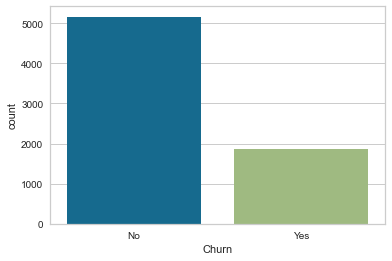

In [26]:
# check distribution of churn
sns.countplot(x='Churn', data=telco)

Data is imbalanced, meaning the accuracy would be cursed by not having equal amounts of yes-churns and no-churns to train on.

Solved by down-sampling(removing records on one side) or up-sampling(copy paste new synthetic samples)

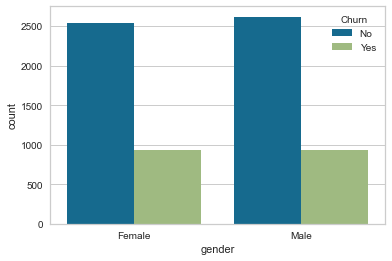

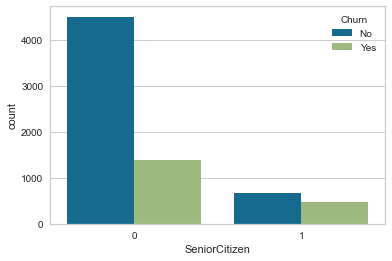

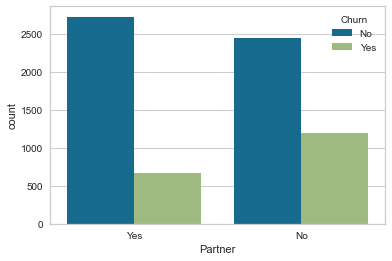

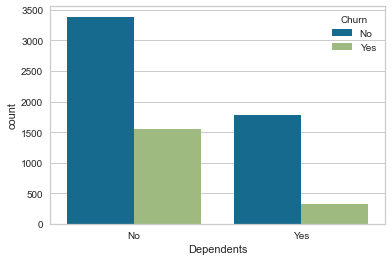

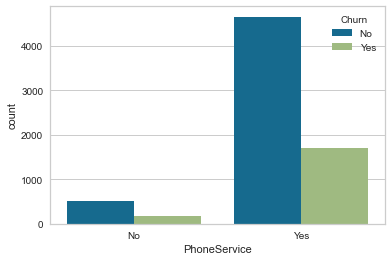

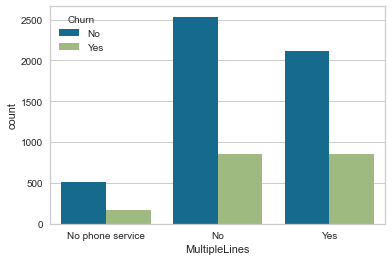

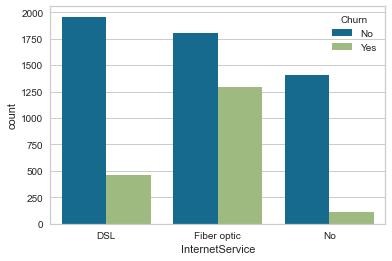

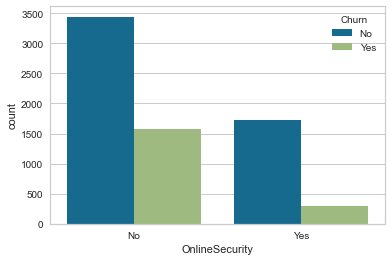

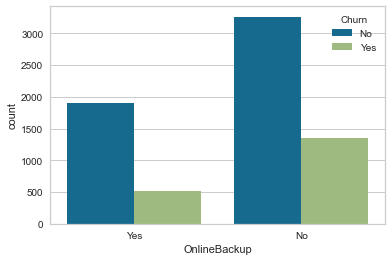

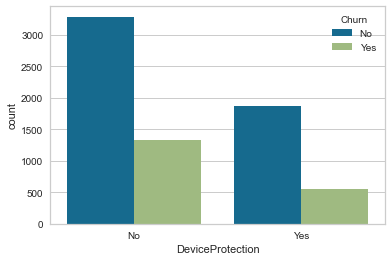

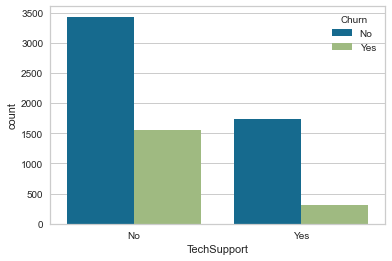

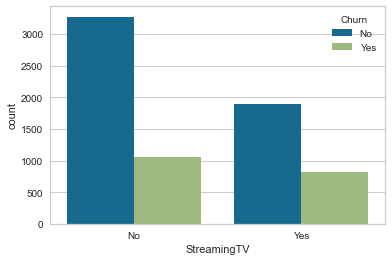

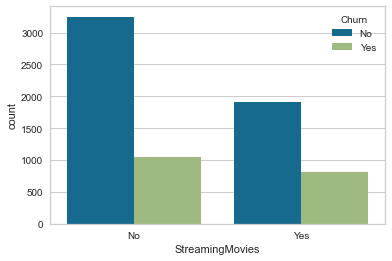

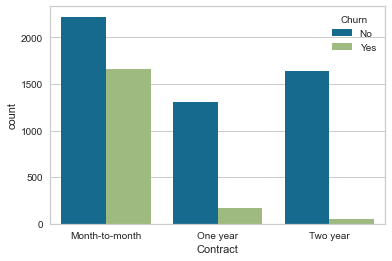

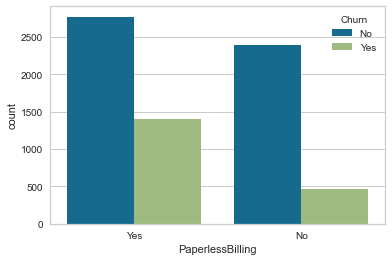

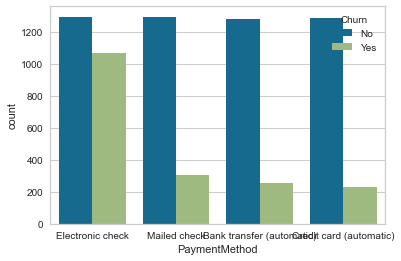

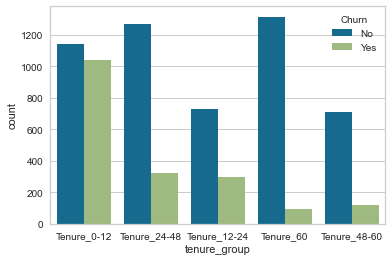

In [27]:
#plot features by churn rate
for i, predictor in enumerate(telco.drop(columns=['customerID','Churn', 'TotalCharges', 'MonthlyCharges','tenure'])):
    plt.figure(i)
    sns.countplot(data=telco, x=predictor, hue='Churn')

Some interesting insights from the plots above:
i.e

1. Gender very close to 50%, it is not standalone important feature.
2. Ratio of churners in SeniorCitizen is very high.
3. More likely to churn if no Partner.
4. People debited automatic on credit card has the lowest churn.
5. People with TechSupport are less likely to churn.


Relationship of Churn with Monthly and Total Charges


Text(0.5, 1.0, 'Monthly Charges by churn')

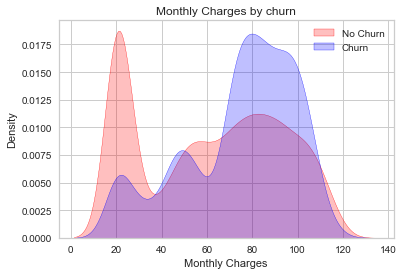

In [28]:
m = sns.kdeplot(telco.MonthlyCharges[(
    telco["Churn"] == 'No')], color='red', shade=True)
m = sns.kdeplot(telco.MonthlyCharges[(
    telco["Churn"] == 'Yes')], color='blue', shade=True, ax=m)
m.legend(['No Churn', 'Churn'], loc='upper right')
m.set_ylabel('Density')
m.set_xlabel('Monthly Charges')
m.set_title('Monthly Charges by churn')


Insight : Churn is high when Monthly Charges are high


Text(0.5, 0, 'Total Charges')

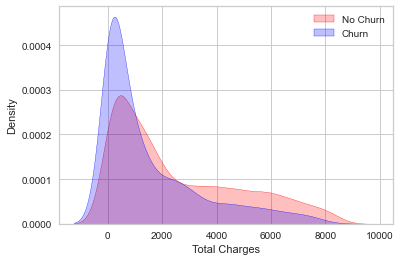

In [29]:
t = sns.kdeplot(telco.TotalCharges[(
    telco["Churn"] == 'No')], color='red', shade=True)
t = sns.kdeplot(telco.TotalCharges[(
    telco["Churn"] == 'Yes')], color='blue', shade=True, ax=t)
t.legend(['No Churn', 'Churn'], loc='upper right')
t.set_ylabel('Density')
t.set_xlabel('Total Charges')


Insight : Higher MonthlyCharge, Lower tenure, Lower TotalCharges are linked to high Churn.

# Data Preprocessing and Further Visualization

In [30]:
DATA = telco.copy()

In [31]:
DATA.rename(columns={"gender": "female"}, inplace=True)
DATA['female'].replace({'Female': 1, 'Male': 0}, inplace=True)

yes_no_columns = ['Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup',
                  'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'PaperlessBilling', 'Churn']
for col in yes_no_columns:
    DATA[col].replace({'Yes': 1, 'No': 0}, inplace=True)

DATA = pd.get_dummies(DATA.drop(['customerID', 'tenure'], axis='columns'))

DATA.sample(5)



,female,SeniorCitizen,Partner,Dependents,PhoneService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,MultipleLines_0,MultipleLines_1,MultipleLines_No phone service,InternetService_DSL,InternetService_Fiber optic,InternetService_No,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,tenure_group_Tenure_0-12,tenure_group_Tenure_12-24,tenure_group_Tenure_24-48,tenure_group_Tenure_48-60,tenure_group_Tenure_60
1121,1,0,0,0,1,1,0,1,1,1,1,1,82.50,4179.10,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0
4045,1,0,0,0,1,0,0,0,0,0,0,1,71.00,914.00,1,1,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0
4231,0,0,0,0,1,1,1,1,1,0,1,0,80.60,5708.20,0,0,1,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,1
6451,0,1,1,1,1,1,1,1,1,1,1,1,116.25,7862.25,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1
1726,0,0,1,0,1,0,0,0,0,0,0,0,49.90,1441.95,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0


# Correlation

Less important features:

In [32]:
corr_df = pd.DataFrame(DATA.corr()['Churn'].sort_values())
less_important_features = corr_df[(
    corr_df.Churn > -0.06) & (corr_df.Churn < 0.06)]
less_important_features


,Churn
MultipleLines_0,-0.032654
MultipleLines_No phone service,-0.011691
female,0.008545
PhoneService,0.011691
tenure_group_Tenure_12-24,0.019929
MultipleLines_1,0.040033


Churn important features:

In [33]:
corr_df.tail(10).sort_index()[1:]


,Churn
Contract_Month-to-month,0.404565
InternetService_Fiber optic,0.307463
MonthlyCharges,0.192858
PaperlessBilling,0.191454
PaymentMethod_Electronic check,0.301455
SeniorCitizen,0.150541
StreamingMovies,0.060860
StreamingTV,0.063254
tenure_group_Tenure_0-12,0.319628


No churn importand features:

In [34]:
corr_df.head(10)


,Churn
Contract_Two year,-0.301552
InternetService_No,-0.227578
tenure_group_Tenure_60,-0.226078
TotalCharges,-0.199484
Contract_One year,-0.178225
OnlineSecurity,-0.171270
TechSupport,-0.164716
Dependents,-0.163128
Partner,-0.149982
PaymentMethod_Credit card (automatic),-0.134687


# Correlation Plot

<AxesSubplot:>

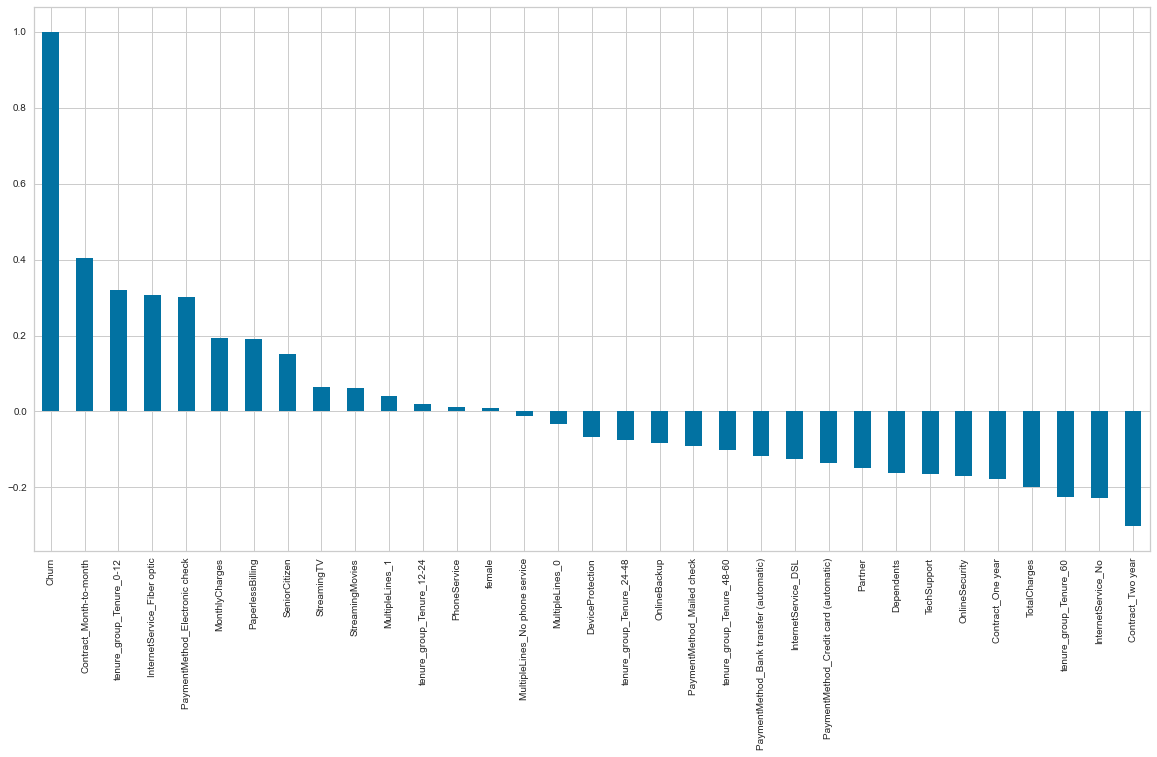

In [35]:
plt.figure(figsize=(20, 10))
DATA.corr()['Churn'].sort_values(ascending=False).plot(kind='bar')

# Correlation Matrix

In [36]:
# correlation
correlation = DATA.corr()
# tick labels
matrix_cols = correlation.columns.tolist()
# convert to array
corr_array = np.array(correlation)
# Plotting
trace = go.Heatmap(z=corr_array,
                   x=matrix_cols,
                   y=matrix_cols,
                   colorscale="tropic",
                   colorbar={'title': "Correlation",
                             'titleside': "right"
                             },
                   )

layout = go.Layout({'title': "Correlation Matrix for variables",
                    'autosize': False,
                    'height': 720,
                    'width': 800,
                    'margin': {'r': 0, 'l': 210,
                               't': 25, 'b': 210,
                               },
                    'yaxis': {'tickfont': {'size': 9}},
                    'xaxis': {'tickfont': {'size': 9}}
                    }
                   )
data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)


# Actual features that Churners had(green) or did not have(grey).

using Plotly<br>
https://plotly.com/python/radar-chart/

In [37]:
binary_cols = DATA.nunique()[DATA.nunique() == 2].keys()
radar_data = DATA[binary_cols]

df = radar_data[radar_data["Churn"] == 1]
df_x = df[binary_cols].sum().reset_index()
df_x.columns = ["feature", "yes"]
df_x["no"] = df.shape[0] - df_x["yes"]
df_x = df_x[df_x["feature"] != "Churn"]


radar1 = go.Scatterpolar(r=df_x["yes"].values.tolist(),
                         theta=df_x["feature"].tolist(),
                         fill="toself", name="count of 1's",
                         mode="markers+lines",
                         marker={'size': 5,'color':'green'}
                         )

radar2 = go.Scatterpolar(r=df_x["no"].values.tolist(),
                         theta=df_x["feature"].tolist(),
                         fill="toself", name="count of 0's",
                         
                         
                         mode="markers+lines",
                         marker={'size': 5,'color':'grey'}
                         )
layout = go.Layout({'polar': {'radialaxis': {'visible': True,
                                             'side': "counterclockwise",
                                             'showline': True,
                                             'linewidth': 2,
                                             'tickwidth': 2,
                                             'gridcolor': "white",
                                             'gridwidth': 2},
                              'angularaxis': {'tickfont': {'size': 10},
                                              'layer': "below traces"
                                              },
                              'bgcolor': "rgb(243,243,243)",
                              },
                    'paper_bgcolor': "rgb(243,243,243)",
                    'title': 'Feature Count where Churn happened Radar Plot', 'height': 700})

data = [radar2, radar1]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)


# Model Building

In [38]:
X = DATA.drop('Churn', axis='columns')
y = DATA.Churn
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [39]:
def test_model(model, xtrain, xtest,
               ytrain, ytest, features = False):
    """
    returns - model, confusion_matrix, classification_report and plots its results
    Function attributes
    model     - model used 
    xtrain    - predictor variables dataframe(training)
    xtest     - predictor variables dataframe(testing)
    ytrain    - target variable(training)
    ytrain    - target variable(testing)
    features - True for tree models
    """
    # model
    model.fit(xtrain, ytrain)
    predictions = model.predict(xtest)
    probabilities = model.predict_proba(xtest)
    # coeffs
    if not features:
        coefficients = pd.DataFrame(model.coef_.ravel())
    elif features:
        coefficients = pd.DataFrame(model.feature_importances_)

    column_df = pd.DataFrame(xtrain.columns)
    coef_sumry = (pd.merge(coefficients, column_df, left_index=True,
                           right_index=True, how="left"))
    coef_sumry.columns = ["coefficients", "features"]
    coef_sumry = coef_sumry.sort_values(by="coefficients", ascending=False)

    print(model)

    # classification report
    cfr = classification_report(ytest, predictions)
    print("\n Classification report : \n",
          cfr)
    print("Accuracy   Score : ", accuracy_score(ytest, predictions))
    # confusion matrix
    conf_matrix = confusion_matrix(ytest, predictions)
    print("\n Confusion Matrix : \n",
          conf_matrix)
    # roc_auc_score
    model_roc_auc = roc_auc_score(ytest, predictions)
    print("Area under curve : ", model_roc_auc, "\n")
    fpr, tpr, thresholds = roc_curve(ytest, probabilities[:, 1])

    # plot confusion matrix
    trace1 = go.Heatmap(z=conf_matrix,
                        x=["Not churn", "Churn"],
                        y=["Not churn", "Churn"],
                        showscale=False, colorscale="Picnic",
                        name="matrix",)

    # plot roc curve
    trace2 = go.Scatter(x=fpr, y=tpr,
                        name="Roc : " + str(model_roc_auc),
                        line={'color':('rgb(22, 96, 167)'), 'width':2})
                        
    trace3 = go.Scatter(x=[0, 1], y=[0, 1],
                        line={'color':('rgb(205, 12, 24)'), 'width':2,
                        'dash':'dot'})

    # plot coeffs
    trace4 = go.Bar(x=coef_sumry["features"], y=coef_sumry["coefficients"],
                    name="coefficients",
                    marker={'color':coef_sumry["coefficients"],
                                'colorscale':"Picnic",
                                'line':{'width':.6, 'color':"black"}})

    # subplots
    fig = tls.make_subplots(rows=2, cols=2, specs=[[{}, {}], [{'colspan': 2}, None]],
                            subplot_titles=('Confusion Matrix(note ticks)',
                                            'Receiver operating characteristic',
                                            'Feature Importances'))

    fig.append_trace(trace1, 1, 1)
    fig.append_trace(trace2, 1, 2)
    fig.append_trace(trace3, 1, 2)
    fig.append_trace(trace4, 2, 1)

    fig['layout'].update(showlegend=False, title="Model performance",
                         autosize=False, height=900, width=800,
                         plot_bgcolor='rgba(240,240,240, 0.95)',
                         paper_bgcolor='rgba(240,240,240, 0.95)',
                         margin={'b':195})
    fig["layout"]["xaxis2"].update({'title':"false positive rate"})
    fig["layout"]["yaxis2"].update({'title':"true positive rate"})
    fig["layout"]["xaxis3"].update({'showgrid':True, 'tickfont':{'size':10},
                                        'tickangle':90})
    py.iplot(fig)
    return model,conf_matrix,cfr


# Model Evaluation (the hard way)

In [40]:
logit  = LogisticRegression()
m0,c0,r0 = test_model(logit,X_train,X_test,y_train,y_test)

LogisticRegression()

 Classification report : 
               precision    recall  f1-score   support

           0       0.84      0.91      0.87      1294
           1       0.67      0.52      0.59       464

    accuracy                           0.81      1758
   macro avg       0.76      0.72      0.73      1758
weighted avg       0.80      0.81      0.80      1758

Accuracy   Score :  0.8065984072810012

 Confusion Matrix : 
 [[1175  119]
 [ 221  243]]
Area under curve :  0.7158719954165113 



In [41]:
treet  = RandomForestClassifier()
tr_model,tr_cm,tr_cr = test_model(treet,X_train,X_test,y_train,y_test,features=True)

RandomForestClassifier()

 Classification report : 
               precision    recall  f1-score   support

           0       0.83      0.90      0.86      1294
           1       0.62      0.47      0.53       464

    accuracy                           0.78      1758
   macro avg       0.72      0.68      0.70      1758
weighted avg       0.77      0.78      0.77      1758

Accuracy   Score :  0.7838452787258248

 Confusion Matrix : 
 [[1160  134]
 [ 246  218]]
Area under curve :  0.6831363587912381 



#### SMOTEENN

Over-sampling using SMOTE(Synthetic Minority Over-sampling Technique) and cleaning using ENN(Edited Nearest Neighbours).

Combine over- and under-sampling using SMOTE and ENN.

In [42]:
SMOTEENN = SMOTEENN()
X_trainSMOTEENN, y_trainSMOTEENN = SMOTEENN.fit_resample(X_train, y_train)

logitSMOTEENN  = LogisticRegression()
m1,c1,r1 = test_model(logitSMOTEENN,X_trainSMOTEENN,X_test,y_trainSMOTEENN,y_test)

LogisticRegression()

 Classification report : 
               precision    recall  f1-score   support

           0       0.90      0.77      0.83      1294
           1       0.54      0.76      0.63       464

    accuracy                           0.76      1758
   macro avg       0.72      0.76      0.73      1758
weighted avg       0.80      0.76      0.77      1758

Accuracy   Score :  0.7639362912400455

 Confusion Matrix : 
 [[990 304]
 [111 353]]
Area under curve :  0.7629227069232 



#### SMOTETomek

Over-sampling using SMOTE and cleaning using Tomek links.

Combine over- and under-sampling using SMOTE and Tomek links. <br> Tomek links are used as an undersampling method and removes noisy and borderline majority class examples

In [43]:
SMOTETomek = SMOTETomek(random_state=42)
X_train_SMOTETomek, y_train_SMOTETomek = SMOTETomek.fit_resample(X_train, y_train)

logitSMOTETomek  = LogisticRegression()
m2,c2,r2 = test_model(logitSMOTETomek,X_train_SMOTETomek,X_test,y_train_SMOTETomek,y_test)

LogisticRegression()

 Classification report : 
               precision    recall  f1-score   support

           0       0.86      0.87      0.86      1294
           1       0.62      0.61      0.62       464

    accuracy                           0.80      1758
   macro avg       0.74      0.74      0.74      1758
weighted avg       0.80      0.80      0.80      1758

Accuracy   Score :  0.7997724687144482

 Confusion Matrix : 
 [[1124  170]
 [ 182  282]]
Area under curve :  0.738191520545755 



# Model Comparision (the hard way)

First we will compare a number of models on the unbalanced data.

In [44]:
# default_classifiers = [['DecisionTree :', DecisionTreeClassifier()],
#                ['RandomForest :', RandomForestClassifier()],
#                ['Naive Bayes :', GaussianNB()],
#                ['KNeighbours :', KNeighborsClassifier()],
#                ['SVM :', SVC()],
#                ['Neural Network :', MLPClassifier()],
#                ['MultinomialNB', MultinomialNB()],
#                ['ExtraTreesClassifier :', ExtraTreesClassifier()],
#                ['AdaBoostClassifier :', AdaBoostClassifier()],
#                ['GradientBoostingClassifier: ', GradientBoostingClassifier()],
#                ['XGB :', XGBClassifier()],
#                ['CatBoost :', CatBoostClassifier(logging_level='Silent')],
#                ['LogisticRegression :', LogisticRegression(max_iter=1000)]]

# default_predictions_df = pd.DataFrame()
# default_predictions_df['actual_labels'] = y_test
# default_models = []
# for name, classifier in default_classifiers:
#     classifier = classifier
#     classifier.fit(X_train, y_train)
#     predictions = classifier.predict(X_test)
#     default_predictions_df[name.strip(" :")] = predictions
#     default_models.append({
#         'model': name.strip(" :")+('(Default)'),
#         'score': accuracy_score(y_test, predictions),
#     })

# default_highscores = pd.DataFrame(default_models, columns=['model', 'score']).sort_values(
#     by='score', ascending=False, ignore_index=True)
    
# default_highscores.to_csv('default_highscores.csv',index=False)


default_highscores = pd.read_csv('default_highscores.csv')
default_highscores

,model,score
0,AdaBoostClassifier(Default),0.807736
1,LogisticRegression(Default),0.807736
2,GradientBoostingClassifier(Default),0.800341
3,Neural Network(Default),0.799772
4,CatBoost(Default),0.793515
5,RandomForest(Default),0.787258
6,XGB(Default),0.786689
7,KNeighbours(Default),0.771900
8,ExtraTreesClassifier(Default),0.767349
9,Naive Bayes(Default),0.748009


We will now compare different models with a balanced dataset.

In [45]:
# resampled_classifiers = [['DecisionTree :', DecisionTreeClassifier()],
#                ['RandomForest :', RandomForestClassifier()],
#                ['Naive Bayes :', GaussianNB()],
#                ['KNeighbours :', KNeighborsClassifier()],
#                ['SVM :', SVC()],
#                ['Neural Network :', MLPClassifier()],
#                ['MultinomialNB', MultinomialNB()],
#                ['ExtraTreesClassifier :', ExtraTreesClassifier()],
#                ['AdaBoostClassifier :', AdaBoostClassifier()],
#                ['GradientBoostingClassifier: ', GradientBoostingClassifier()],
#                ['XGB :', XGBClassifier()],
#                ['CatBoost :', CatBoostClassifier(logging_level='Silent')],
#                ['LogisticRegression :', LogisticRegression(max_iter=1000)]]

# resampled_predictions_df = pd.DataFrame()
# resampled_predictions_df['actual_labels'] = y_test
# resampled_models = []
# for name, classifier in resampled_classifiers:
#     classifier = classifier
#     classifier.fit(X_trainSMOTEENN, y_trainSMOTEENN)
#     predictions = classifier.predict(X_test)
#     resampled_predictions_df[name.strip(" :")] = predictions
#     resampled_models.append({
#         'model': name.strip(" :")+('(SMOTEENN)'),
#         'score': accuracy_score(y_test, predictions),
#     })

# resampled_highscores = pd.DataFrame(resampled_models, columns=['model', 'score']).sort_values(
#     by='score', ascending=False, ignore_index=True)


# resampled_highscores.to_csv('resampled_highscores.csv',index=False)


resampled_highscores = pd.read_csv('resampled_highscores.csv')
resampled_highscores

,model,score
0,Neural Network(SMOTEENN),0.784414
1,Naive Bayes(SMOTEENN),0.775313
2,LogisticRegression(SMOTEENN),0.773606
3,ExtraTreesClassifier(SMOTEENN),0.766212
4,AdaBoostClassifier(SMOTEENN),0.762799
5,RandomForest(SMOTEENN),0.755973
6,GradientBoostingClassifier(SMOTEENN),0.755973
7,CatBoost(SMOTEENN),0.754266
8,XGB(SMOTEENN),0.748009
9,DecisionTree(SMOTEENN),0.739477


# Oversampling

In [46]:
smote = SMOTE()

In [47]:
X_train_SMOTE, y_train_SMOTE = smote.fit_resample(X_train,y_train)

In [48]:
# oversample_classifiers = [['DecisionTree :', DecisionTreeClassifier()],
#                ['RandomForest :', RandomForestClassifier()],
#                ['Naive Bayes :', GaussianNB()],
#                ['KNeighbours :', KNeighborsClassifier()],
#                ['SVM :', SVC()],
#                ['Neural Network :', MLPClassifier()],
#                ['MultinomialNB', MultinomialNB()],
#                ['ExtraTreesClassifier :', ExtraTreesClassifier()],
#                ['AdaBoostClassifier :', AdaBoostClassifier()],
#                ['GradientBoostingClassifier: ', GradientBoostingClassifier()],
#                ['XGB :', XGBClassifier()],
#                ['CatBoost :', CatBoostClassifier(logging_level='Silent')],
#                ['LogisticRegression :', LogisticRegression(max_iter=1000)]]

# oversample_predictions_df = pd.DataFrame()
# oversample_predictions_df['actual_labels'] = y_test
# oversample_models = []
# for name, classifier in oversample_classifiers:
#     classifier = classifier
#     classifier.fit(X_train_SMOTE, y_train_SMOTE)
#     predictions = classifier.predict(X_test)
#     oversample_predictions_df[name.strip(" :")] = predictions
#     oversample_models.append({
#         'model': name.strip(" :")+('(OverSample)'),
#         'score': accuracy_score(y_test, predictions),
#     })
# oversample_highscores = pd.DataFrame(oversample_models, columns=['model', 'score']).sort_values(
#     by='score', ascending=False, ignore_index=True)


# oversample_highscores.to_csv('oversample_highscores.csv',index=False)


oversample_highscores = pd.read_csv('oversample_highscores.csv')
oversample_highscores

,model,score
0,LogisticRegression(OverSample),0.799772
1,CatBoost(OverSample),0.793515
2,Neural Network(OverSample),0.792947
3,GradientBoostingClassifier(OverSample),0.788396
4,XGB(OverSample),0.782708
5,AdaBoostClassifier(OverSample),0.782139
6,RandomForest(OverSample),0.771900
7,Naive Bayes(OverSample),0.771331
8,ExtraTreesClassifier(OverSample),0.765643
9,DecisionTree(OverSample),0.721274


# MinMaxScaler

In [49]:
DATA1 = DATA.copy()
MinMaxScaler = MinMaxScaler()
MinMaxScaler.fit(DATA1[['MonthlyCharges']])
DATA1['MonthlyCharges'] = MinMaxScaler.transform(DATA1[['MonthlyCharges']])
MinMaxScaler.fit(DATA1[['TotalCharges']])
DATA1['TotalCharges'] = MinMaxScaler.transform(DATA1[['TotalCharges']])


X_scaled = DATA1.drop('Churn',axis='columns')
y_scaled = DATA1.Churn

X_train_scaled,X_test_scaled,y_train_scaled,y_test_scaled = train_test_split(X_scaled,y_scaled,random_state = 1)


In [50]:

# classifiers_mm = [['DecisionTree :', DecisionTreeClassifier()],
#                   ['RandomForest :', RandomForestClassifier()],
#                   ['Naive Bayes :', GaussianNB()],
#                   ['KNeighbours :', KNeighborsClassifier()],
#                   ['SVM :', SVC()],
#                   ['Neural Network :', MLPClassifier()],
#                   ['MultinomialNB', MultinomialNB()],
#                   ['ExtraTreesClassifier :', ExtraTreesClassifier()],
#                   ['AdaBoostClassifier :', AdaBoostClassifier()],
#                   ['GradientBoostingClassifier: ', GradientBoostingClassifier()],
#                   ['XGB :', XGBClassifier()],
#                   ['CatBoost :', CatBoostClassifier(logging_level='Silent')],
#                   ['LogisticRegression :', LogisticRegression(max_iter=1000)]]

# predictions_df_mm = pd.DataFrame()
# predictions_df_mm['actual_labels'] = y_test_scaled
# models_mm = []
# for name, classifier in classifiers_mm:
#     classifier = classifier
#     classifier.fit(X_train_scaled, y_train_scaled)
#     predictions = classifier.predict(X_test_scaled)
#     predictions_df_mm[name.strip(" :")] = predictions
#     models_mm.append({
#         'model': name.strip(" :")+'(MinMaxScaler)',
#         'score': accuracy_score(y_test_scaled, predictions),
#     })

# highscores_mm = pd.DataFrame(models_mm, columns=['model', 'score']).sort_values(
#     by='score', ascending=False, ignore_index=True)

# highscores_mm.to_csv('highscores_mm.csv',index=False)


highscores_mm = pd.read_csv('highscores_mm.csv')
highscores_mm


,model,score
0,AdaBoostClassifier(MinMaxScaler),0.807736
1,LogisticRegression(MinMaxScaler),0.800910
2,GradientBoostingClassifier(MinMaxScaler),0.800341
3,SVM(MinMaxScaler),0.799772
4,MultinomialNB(MinMaxScaler),0.799204
5,CatBoost(MinMaxScaler),0.793515
6,XGB(MinMaxScaler),0.786689
7,RandomForest(MinMaxScaler),0.781570
8,Neural Network(MinMaxScaler),0.772469
9,KNeighbours(MinMaxScaler),0.770193


# MinMaxScaler & SMOTEENN

In [51]:

X_train_scaledSMOTEENN,y_train_scaledSMOTEENN = SMOTEENN.fit_resample(X_train_scaled, y_train_scaled)


In [52]:

# classifiers_sc_mm = [['DecisionTree :', DecisionTreeClassifier()],
#                   ['RandomForest :', RandomForestClassifier()],
#                   ['Naive Bayes :', GaussianNB()],
#                   ['KNeighbours :', KNeighborsClassifier()],
#                   ['SVM :', SVC()],
#                   ['Neural Network :', MLPClassifier()],
#                   ['MultinomialNB', MultinomialNB()],
#                   ['ExtraTreesClassifier :', ExtraTreesClassifier()],
#                   ['AdaBoostClassifier :', AdaBoostClassifier()],
#                   ['GradientBoostingClassifier: ', GradientBoostingClassifier()],
#                   ['XGB :', XGBClassifier()],
#                   ['CatBoost :', CatBoostClassifier(logging_level='Silent')],
#                   ['LogisticRegression :', LogisticRegression(max_iter=1000)]]

# predictions_df_sc_mm = pd.DataFrame()
# predictions_df_sc_mm['actual_labels'] = y_test_scaled
# models_sc_mm = []
# for name, classifier in classifiers_sc_mm:
#     classifier = classifier
#     classifier.fit(X_train_scaledSMOTEENN, y_train_scaledSMOTEENN)
#     predictions = classifier.predict(X_test_scaled)
#     predictions_df_sc_mm[name.strip(" :")] = predictions
#     models_sc_mm.append({
#         'model': name.strip(" :")+'(MinMaxScaler,SMOTEENN)',
#         'score': accuracy_score(y_test_scaled, predictions),
#     })

# highscores_sc_mm = pd.DataFrame(models_sc_mm, columns=['model', 'score']).sort_values(
#     by='score', ascending=False, ignore_index=True)
# highscores_sc_mm.to_csv('highscores_sc_mm.csv',index=False)


highscores_sc_mm = pd.read_csv('highscores_sc_mm.csv')
highscores_sc_mm


,model,score
0,"Neural Network(MinMaxScaler,SMOTEENN)",0.742321
1,"Naive Bayes(MinMaxScaler,SMOTEENN)",0.736064
2,"RandomForest(MinMaxScaler,SMOTEENN)",0.730944
3,"ExtraTreesClassifier(MinMaxScaler,SMOTEENN)",0.729238
4,"XGB(MinMaxScaler,SMOTEENN)",0.728669
5,"LogisticRegression(MinMaxScaler,SMOTEENN)",0.726962
6,"SVM(MinMaxScaler,SMOTEENN)",0.725825
7,"CatBoost(MinMaxScaler,SMOTEENN)",0.724687
8,"GradientBoostingClassifier(MinMaxScaler,SMOTEENN)",0.721843
9,"MultinomialNB(MinMaxScaler,SMOTEENN)",0.717292


# Grid Search, MinMaxScaler & SMOTEENN

In [53]:
# model_params_sc = {
#     'RandomForest(MinMaxScaler,GridSearch,SMOTEENN)': {
#         'model': RandomForestClassifier(),
#         'params': {
#             'criterion': ['gini', 'entropy'],
#             'n_estimators': [100],
#             'max_depth': [6, 12],
#             'min_samples_leaf': [8, 16]
#         }
#     },
#     'ExtraTreesClassifier(MinMaxScaler,GridSearch,SMOTEENN)': {
#         'model': ExtraTreesClassifier(),
#         'params': {
#             'criterion': ['gini', 'entropy', 'log_loss'],
#             "n_estimators": [100],
#             "max_depth": [6,32]
#         }
#     },
#     'XGB(MinMaxScaler,GridSearch,SMOTEENN)': {
#         'model': XGBClassifier(),
#         'params': {
#             'min_child_weight': [1, 5, 10],
#             'gamma': [0.5, 1, 1.5, 2, 5],
#             'subsample': [0.6, 0.8, 1.0],
#             'colsample_bytree': [0.6, 0.8, 1.0],
#             'max_depth': [3, 4, 5]
#         }
#     }
# }

# scores_sc = []
# for model_name, mp in model_params_sc.items():
#     clf = GridSearchCV(mp['model'], mp['params'],
#                        cv=5, return_train_score=False,scoring='accuracy')
#     clf.fit(X_train_scaledSMOTEENN, y_train_scaledSMOTEENN)
#     scores_sc.append({
#         'model': model_name,
#         'best_score': clf.score(X_test_scaled,y_test_scaled),
#         'best_params': clf.best_params_
#     })
# grid_search_sc = pd.DataFrame(scores_sc, columns=[
#                            'model', 'best_score', 'best_params']).sort_values(by='best_score', ascending=False)
                           
# grid_search_sc.to_csv('scaled_grid_search.csv',index=False)


In [54]:
grid_search_sc = pd.read_csv('scaled_grid_search.csv')
grid_search_sc

,model,best_score,best_params
0,"ExtraTreesClassifier(MinMaxScaler,GridSearch,SMOTEENN)",0.729807,"{'criterion': 'log_loss', 'max_depth': 32, 'n_estimators': 100}"
1,"XGB(MinMaxScaler,GridSearch,SMOTEENN)",0.727531,"{'colsample_bytree': 0.6, 'gamma': 0.5, 'max_depth': 5, 'min_child_weight': 1, 'subsample': 1.0}"
2,"RandomForest(MinMaxScaler,GridSearch,SMOTEENN)",0.715586,"{'criterion': 'gini', 'max_depth': 12, 'min_samples_leaf': 8, 'n_estimators': 100}"


# Grid Search, SMOTEENN

In [55]:


# model_params = {
#     'RandomForest(GridSearch,SMOTEENN)':{
#         'model':RandomForestClassifier(),
#         'params':{
#             'criterion':['gini','entropy'],
#             'n_estimators':[50,100],
#             'max_depth':[6,12],
#             'min_samples_leaf':[8,16]
#         }
#     },
#     'ExtraTreesClassifier(GridSearch,SMOTEENN)':{
#         'model':ExtraTreesClassifier(),
#         'params':{
#             'criterion':['gini','entropy','log_loss'],
#         }
#     },
#     'KNeighbours(GridSearch,SMOTEENN)':{
#         'model':KNeighborsClassifier(),
#         'params':{
#             'n_neighbors':[5,10],
#             'weights':['uniform','distance'],
#             'algorithm':['ball_tree','kd_tree','brute','auto']
#         }
#     }
# }

# scores = []
# for model_name,mp in model_params.items():
#     clf = GridSearchCV(mp['model'],mp['params'],cv=5,return_train_score=False,scoring='accuracy')
#     clf.fit(X_trainSMOTEENN,y_trainSMOTEENN)
#     scores.append({
#         'model':model_name,
#         'best_score':clf.score(X_test_scaled,y_test_scaled),
#         'best_params':clf.best_params_
#     })
# grid_search = pd.DataFrame(scores,columns=['model','best_score','best_params']).sort_values(by='best_score',ascending=False)
# grid_search.to_csv('grid_search.csv',index=False)

In [56]:
grid_search = pd.read_csv('grid_search.csv')
grid_search

,model,best_score,best_params
0,"RandomForest(GridSearch,SMOTEENN)",0.783845,"{'criterion': 'gini', 'max_depth': 12, 'min_samples_leaf': 8, 'n_estimators': 100}"
1,"ExtraTreesClassifier(GridSearch,SMOTEENN)",0.768487,{'criterion': 'log_loss'}
2,"KNeighbours(GridSearch,SMOTEENN)",0.736064,"{'algorithm': 'ball_tree', 'n_neighbors': 5, 'weights': 'distance'}"


# Recursive Feature Elimination
Recursive Feature Elimination (RFE) is based on the idea to repeatedly construct a model and choose either the best or worst performing feature, setting the feature aside and then repeating the process with the rest of the features. This process is applied until all features in the dataset are exhausted. The goal of RFE is to select features by recursively considering smaller and smaller sets of features.

In [57]:
from sklearn.feature_selection import RFE

rfe = RFE(LogisticRegression())
rfe = rfe.fit(X_train_scaledSMOTEENN,y_train_scaledSMOTEENN.values.ravel())

idc_rfe = pd.DataFrame({"rfe_support" :rfe.support_,
                       "columns" : [col for col in X.columns],
                       "ranking" : rfe.ranking_,
                      })
cols = idc_rfe[idc_rfe["rfe_support"] == True]["columns"].tolist()


logit_rfe = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


test_model(logit_rfe,X_train_scaledSMOTEENN[cols],X_test_scaled[cols],y_train_scaledSMOTEENN,y_test_scaled)

tab_rk = ff.create_table(idc_rfe)
py.iplot(tab_rk)

LogisticRegression(multi_class='ovr', n_jobs=1, solver='liblinear')

 Classification report : 
               precision    recall  f1-score   support

           0       0.93      0.67      0.78      1294
           1       0.48      0.86      0.62       464

    accuracy                           0.72      1758
   macro avg       0.71      0.77      0.70      1758
weighted avg       0.81      0.72      0.74      1758

Accuracy   Score :  0.7212741751990899

 Confusion Matrix : 
 [[870 424]
 [ 66 398]]
Area under curve :  0.7650462346106699 



# PCA
Linear dimensionality reduction using Singular Value Decomposition of the data to project it to a lower dimensional space. <br> The input data is centered but not scaled for each feature before applying the SVD.

In [58]:
pca = PCA(n_components=25)


X_scaled = MinMaxScaler.fit_transform(X)
X_scaled_pca = pca.fit_transform(X_scaled)


X_train_pca, X_test_pca,y_train_pca,y_test_pca = train_test_split(X_scaled_pca,y,test_size=0.2,random_state=30)

X_train_scaled_pca = MinMaxScaler.fit_transform(X_train_pca)



classifiers_pca= [['DecisionTree :', DecisionTreeClassifier()],
                  ['RandomForest :', RandomForestClassifier()],
                  ['Naive Bayes :', GaussianNB()],
                  ['KNeighbours :', KNeighborsClassifier()],
                  ['SVM :', SVC()],
                  ['Neural Network :', MLPClassifier()],
                  ['ExtraTreesClassifier :', ExtraTreesClassifier()],
                  ['AdaBoostClassifier :', AdaBoostClassifier()],
                  ['GradientBoostingClassifier: ', GradientBoostingClassifier()],
                  ['XGB :', XGBClassifier()],
                  ['CatBoost :', CatBoostClassifier(logging_level='Silent')],
                  ['LogisticRegression :', LogisticRegression(max_iter=1000)]]

predictions_df_pca= pd.DataFrame()
predictions_df_pca['actual_labels'] = y_test_pca
models_pca= []
for name, classifier in classifiers_pca:
    classifier = classifier
    classifier.fit(X_train_scaled_pca, y_train_pca)
    predictions = classifier.predict(X_test_pca)

    predictions_df_pca[name.strip(" :")] = predictions
    models_pca.append({
        'model': name.strip(" :")+'(PCA)',
        'score': accuracy_score(y_test_pca, predictions),
    })

highscores_pca= pd.DataFrame(models_pca, columns=['model', 'score']).sort_values(
    by='score', ascending=False, ignore_index=True)
highscores_pca


,model,score
0,KNeighbours(PCA),0.752665
1,ExtraTreesClassifier(PCA),0.734186
2,Naive Bayes(PCA),0.732765
3,SVM(PCA),0.732765
4,AdaBoostClassifier(PCA),0.729922
5,XGB(PCA),0.686567
6,CatBoost(PCA),0.673774
7,Neural Network(PCA),0.669510
8,LogisticRegression(PCA),0.643923
9,DecisionTree(PCA),0.434968


![alt text](pca.jpg "Title")

# Neural Network Example

In [59]:
ann = keras.Sequential([
    keras.layers.Dense(26, input_shape=(32,), activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(15, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

ann.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

ann.fit(X_train, y_train, epochs=100)
keras_score = ann.evaluate(X_test, y_test)[1]

Epoch 1/100
165/165 [==============================] - 3s 3ms/step - loss: 67.9922 - accuracy: 0.5916
Epoch 2/100
165/165 [==============================] - 0s 2ms/step - loss: 19.1448 - accuracy: 0.6270
Epoch 3/100
165/165 [==============================] - 0s 2ms/step - loss: 7.8263 - accuracy: 0.6576
Epoch 4/100
165/165 [==============================] - 0s 2ms/step - loss: 4.6251 - accuracy: 0.6807
Epoch 5/100
165/165 [==============================] - 0s 2ms/step - loss: 2.6374 - accuracy: 0.7069
Epoch 6/100
165/165 [==============================] - 0s 2ms/step - loss: 2.0376 - accuracy: 0.7175
Epoch 7/100
165/165 [==============================] - 0s 2ms/step - loss: 1.5031 - accuracy: 0.7089
Epoch 8/100
165/165 [==============================] - 0s 2ms/step - loss: 1.4734 - accuracy: 0.7253
Epoch 9/100
165/165 [==============================] - 0s 2ms/step - loss: 1.0681 - accuracy: 0.7224
Epoch 10/100
165/165 [==============================] - 0s 2ms/step - loss: 0.9804 - accu

In [60]:
yp_ann = ann.predict(X_test)
y_pred_ann = []
for element in yp_ann:
    if element > 0.5:
        y_pred_ann.append(1)
    else:
        y_pred_ann.append(0)
print(classification_report(y_test,y_pred_ann))

55/55 [==============================] - 0s 834us/step
              precision    recall  f1-score   support

           0       0.75      1.00      0.86      1294
           1       0.92      0.10      0.18       464

    accuracy                           0.76      1758
   macro avg       0.84      0.55      0.52      1758
weighted avg       0.80      0.76      0.68      1758



### Recall for class 1 is below all critic!

Text(70.0, 0.5, 'Truth')

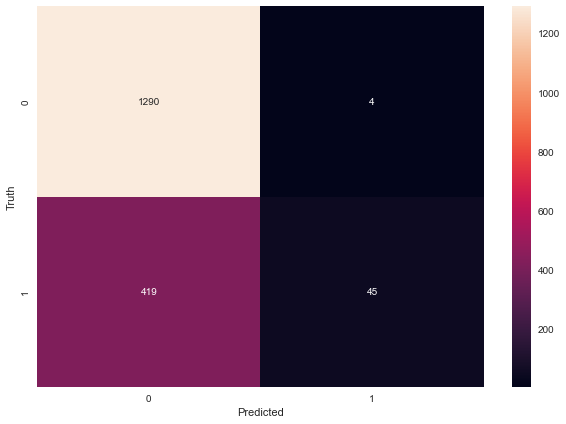

In [61]:
cm_ann = tf.math.confusion_matrix(labels=y_test,predictions=y_pred_ann)
plt.figure(figsize = (10,7))
sns.heatmap(cm_ann, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [62]:
ann_rs = keras.Sequential([
    keras.layers.Dense(26, input_shape=(32,), activation='leaky_relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(15, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])
ann_rs.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
ann_rs.fit(X_trainSMOTEENN, y_trainSMOTEENN, epochs=100)

keras_rs_score = ann_rs.evaluate(X_test, y_test)[1]

Epoch 1/100
134/134 [==============================] - 1s 3ms/step - loss: 30.1464 - accuracy: 0.6157
Epoch 2/100
134/134 [==============================] - 0s 3ms/step - loss: 12.5400 - accuracy: 0.6786
Epoch 3/100
134/134 [==============================] - 0s 2ms/step - loss: 7.7598 - accuracy: 0.6913
Epoch 4/100
134/134 [==============================] - 0s 2ms/step - loss: 4.7068 - accuracy: 0.7151
Epoch 5/100
134/134 [==============================] - 0s 2ms/step - loss: 3.0408 - accuracy: 0.7468
Epoch 6/100
134/134 [==============================] - 0s 2ms/step - loss: 2.2334 - accuracy: 0.7477
Epoch 7/100
134/134 [==============================] - 0s 2ms/step - loss: 1.8956 - accuracy: 0.7653
Epoch 8/100
134/134 [==============================] - 0s 2ms/step - loss: 1.6242 - accuracy: 0.7764
Epoch 9/100
134/134 [==============================] - 0s 2ms/step - loss: 1.0484 - accuracy: 0.8020
Epoch 10/100
134/134 [==============================] - 0s 2ms/step - loss: 0.8713 - accu

In [63]:
yp_rs = ann_rs.predict(X_test)
y_pred_rs = []
for element in yp_rs:
    if element > 0.5:
        y_pred_rs.append(1)
    else:
        y_pred_rs.append(0)

print(classification_report(y_test,y_pred_rs))


55/55 [==============================] - 0s 815us/step
              precision    recall  f1-score   support

           0       0.91      0.72      0.80      1294
           1       0.51      0.81      0.62       464

    accuracy                           0.74      1758
   macro avg       0.71      0.76      0.71      1758
weighted avg       0.81      0.74      0.75      1758



Text(70.0, 0.5, 'Truth')

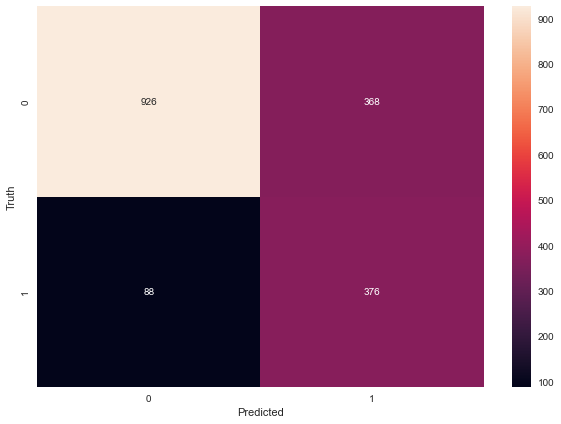

In [64]:


cm_rs = tf.math.confusion_matrix(labels=y_test,predictions=y_pred_rs)
plt.figure(figsize = (10,7))
sns.heatmap(cm_rs, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

Comparing these two we should always try to balance the dataset when working with a neural network like this.

![alt text](nn.jpg "Title")

# Comparision Yield Below

In [65]:
dict = {
    'Keras Sequential(Default)': keras_score,
    'Keras Sequential(SMOTEENN)': keras_rs_score,
}
dict_df = pd.DataFrame(list(dict.items()), columns=['model', 'score'])

In [66]:
grid_search.rename(columns={'best_score': 'score'}, inplace=True) # format before concat 
grid_search_sc.rename(columns={'best_score': 'score'}, inplace=True) # format before concat
conclusion = pd.concat([oversample_highscores,dict_df,default_highscores, resampled_highscores, highscores_mm,highscores_sc_mm, grid_search, grid_search_sc,highscores_pca]).sort_values(
    by='score', ascending=False, ignore_index=True).drop('best_params', axis='columns') # score overview dataframe
conclusion

,model,score
0,AdaBoostClassifier(Default),0.807736
1,AdaBoostClassifier(MinMaxScaler),0.807736
2,LogisticRegression(Default),0.807736
3,LogisticRegression(MinMaxScaler),0.800910
4,GradientBoostingClassifier(MinMaxScaler),0.800341
5,GradientBoostingClassifier(Default),0.800341
6,SVM(MinMaxScaler),0.799772
7,Neural Network(Default),0.799772
8,LogisticRegression(OverSample),0.799772
9,MultinomialNB(MinMaxScaler),0.799204


# Model Comparision (the easy way)

using PyCaret<br>
https://pycaret.gitbook.io/docs/

PyCaret is an open-source, low-code machine learning library in Python that automates machine learning workflows. It is an end-to-end machine learning and model management tool that exponentially speeds up the experiment cycle and makes you more productive.

In [67]:
# raise Exception('Comment this line to fasten seatbelt.')

In [68]:
s = setup(SECRET_DATA,  # Data from cell #6 in this notebook, with 11 NaN values.
          target='Churn',
          normalize=True,
          fix_imbalance=True, 
          ignore_features=['customerID'],
          use_gpu=True,
          pca=False,
          max_encoding_ohe=-1
          # there are many many more input parameters there available in the docs
          )


,Description,Value
0,Session id,1628
1,Target,Churn
2,Target type,Binary
3,Target mapping,"No: 0, Yes: 1"
4,Original data shape,"(7043, 20)"
5,Transformed data shape,"(9357, 41)"
6,Transformed train set shape,"(7244, 41)"
7,Transformed test set shape,"(2113, 41)"
8,Ignore features,1
9,Ordinal features,5


In [69]:
#Compare models and sort by F1 score
best_model = compare_models(sort='F1')
# Find best parameters for chosen model
tuned_best_model = tune_model(estimator=best_model, optimize="F1")
# Best model parameters
plot_model(tuned_best_model, plot="parameter")


,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,08:36:39
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Extreme Gradient Boosting


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.7517,0.8415,0.7959,0.5214,0.6298,0.4551,0.4784,1.2230
ridge,Ridge Classifier,0.7479,0.0000,0.7966,0.5164,0.6263,0.4489,0.4734,0.3180
lda,Linear Discriminant Analysis,0.7479,0.8383,0.7966,0.5164,0.6263,0.4489,0.4734,0.3880
ada,Ada Boost Classifier,0.7972,0.8438,0.6323,0.6151,0.6232,0.4846,0.4849,0.7050
gbc,Gradient Boosting Classifier,0.7947,0.8420,0.5803,0.6219,0.5996,0.4620,0.4630,1.5450
nb,Naive Bayes,0.6984,0.8167,0.8395,0.4624,0.5963,0.3863,0.4303,0.3710
svm,SVM - Linear Kernel,0.7227,0.0000,0.7470,0.4865,0.5883,0.3935,0.4149,0.3610
knn,K Neighbors Classifier,0.6905,0.7561,0.7126,0.4478,0.5498,0.3322,0.3533,0.4350
rf,Random Forest Classifier,0.7805,0.8143,0.4947,0.6050,0.5435,0.4013,0.4051,1.0240
et,Extra Trees Classifier,0.7700,0.7870,0.4893,0.5787,0.5300,0.3792,0.3817,0.6370


Processing:   0%|          | 0/69 [00:00<?, ?it/s]

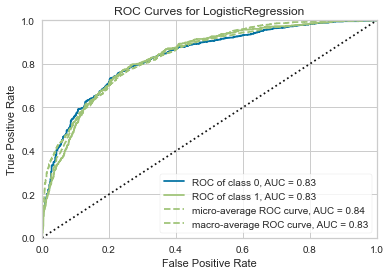

In [ ]:
# receiver operating characteristic curve
plot_model(tuned_best_model, plot = 'auc')


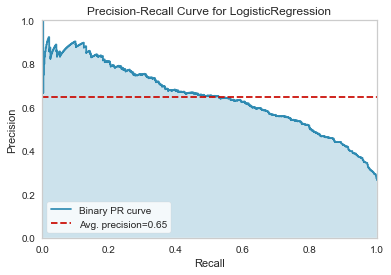

In [ ]:
# Precision recall curve
plot_model(tuned_best_model, plot="pr")


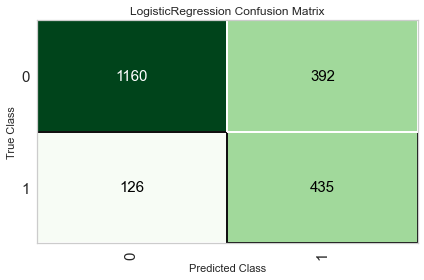

In [ ]:
# Confusion matrix
plot_model(tuned_best_model, plot = 'confusion_matrix')


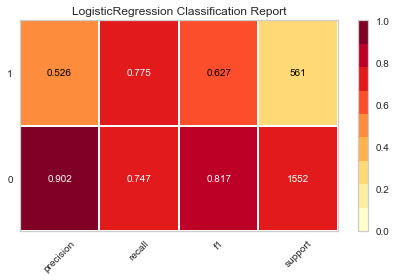

In [ ]:
# Classification report
plot_model(tuned_best_model, plot="class_report")


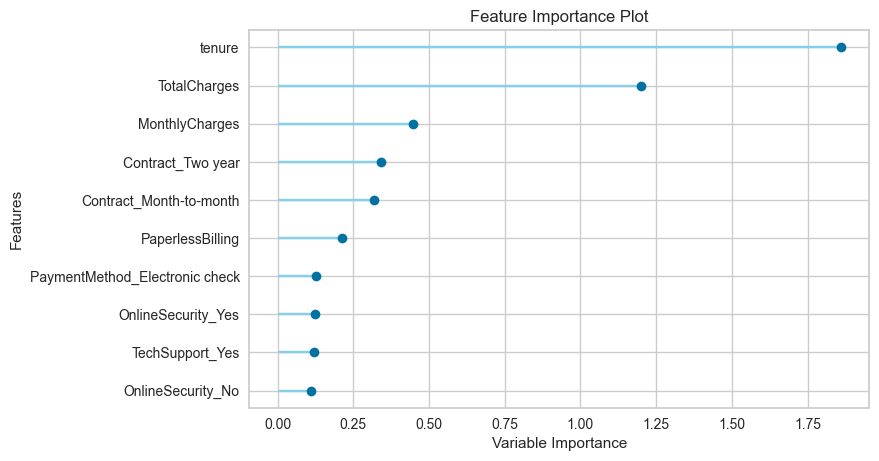

In [ ]:
# Feature importance plot
plot_model(tuned_best_model, plot = 'feature')


In [ ]:
# Actual predictions
predict_model(tuned_best_model)


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.7549,0.8343,0,0,0,0.4541,0.4731


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,...,PaperlessBilling,PaymentMethod_Electronic check,PaymentMethod_Mailed check,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),MonthlyCharges,TotalCharges,Churn,Label,Score
4930,1.057536,-0.511748,1.187300,1.764107,1.823871,0.324764,1.104079,-0.324764,-0.915573,-1.074406,...,-1.427099,-0.880034,2.011690,-0.512679,-0.495871,-1.683532,-0.298778,No,No,0.9992
4931,1.057536,-0.511748,1.187300,-0.611210,1.865789,0.324764,-0.977578,-0.324764,1.171375,-1.074406,...,0.757301,-0.880034,-0.527758,2.115855,-0.495871,-0.020773,1.255293,No,No,0.9900
4932,-1.049391,2.240979,1.187300,1.764107,-0.649285,-3.217953,-0.977578,3.217953,-0.915573,-1.074406,...,0.757301,-0.880034,2.011690,-0.512679,-0.495871,-1.354444,-0.773129,No,Yes,0.5492
4933,-1.049391,-0.511748,1.187300,-0.611210,1.278938,-3.217953,-0.977578,3.217953,-0.915573,-1.074406,...,0.757301,1.257931,-0.527758,-0.512679,-0.495871,-0.798459,0.222764,No,No,0.9279
4934,1.057536,-0.511748,1.187300,-0.611210,-1.110382,0.324764,1.104079,-0.324764,-0.915573,0.949381,...,0.757301,1.257931,-0.527758,-0.512679,-0.495871,0.568121,-0.896737,Yes,Yes,0.8653
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,1.057536,-0.511748,1.187300,1.764107,1.865789,0.324764,-0.977578,-0.324764,1.171375,0.949381,...,0.757301,-0.880034,-0.527758,-0.512679,2.177139,1.385644,2.606100,No,No,0.8667
7039,1.057536,2.240979,-0.925551,-0.611210,-1.026546,0.324764,-0.977578,-0.324764,1.171375,0.949381,...,0.757301,1.257931,-0.527758,-0.512679,-0.495871,0.265014,-0.829712,Yes,Yes,0.9149
7040,-1.049391,-0.511748,1.187300,-0.611210,-0.942710,0.324764,1.104079,-0.324764,-0.915573,0.949381,...,0.757301,-0.880034,2.011690,-0.512679,-0.495871,0.710148,-0.728331,Yes,Yes,0.7309
7041,-1.049391,2.240979,-0.925551,-0.611210,0.314826,0.324764,-0.977578,-0.324764,1.171375,0.949381,...,0.757301,1.257931,-0.527758,-0.512679,-0.495871,1.061753,0.685329,No,Yes,0.8253


# Everything above in 6 lines of code.
using PyCaret AutoML.

In [ ]:
# using clean data because of the many random and unique cols and values(tenure,customerId) in this dataset, saves us some time.
clf1 = setup(DATA, target = 'Churn') 
# compare models
top5 = compare_models(n_select = 5) 
# tune models
tuned_top5 = [tune_model(i) for i in top5]
# ensemble models
bagged_top5 = [ensemble_model(i) for i in tuned_top5]
# blend models
blender = blend_models(estimator_list = top5) 
# stack models
stacker = stack_models(estimator_list = top5) 


,Description,Value
0,Session id,1792
1,Target,Churn
2,Target type,Binary
3,Original data shape,"(7032, 33)"
4,Transformed data shape,"(7032, 33)"
5,Transformed train set shape,"(4922, 33)"
6,Transformed test set shape,"(2110, 33)"
7,Numeric features,32
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ada,Ada Boost Classifier,0.8019,0.8375,0.5367,0.6558,0.5895,0.4609,0.4654,0.0460
lr,Logistic Regression,0.7985,0.8361,0.5077,0.6580,0.5720,0.4432,0.4503,0.0470
lda,Linear Discriminant Analysis,0.7960,0.8335,0.5115,0.6491,0.5710,0.4398,0.4459,0.0140
gbc,Gradient Boosting Classifier,0.7956,0.8352,0.5153,0.6461,0.5722,0.4404,0.4459,0.0900
ridge,Ridge Classifier,0.7952,0.0000,0.4672,0.6651,0.5474,0.4205,0.4322,0.0160
catboost,CatBoost Classifier,0.7936,0.8314,0.5008,0.6459,0.5627,0.4307,0.4375,0.9590
lightgbm,Light Gradient Boosting Machine,0.7897,0.8224,0.5061,0.6328,0.5610,0.4252,0.4307,0.0380
rf,Random Forest Classifier,0.7818,0.8129,0.4648,0.6222,0.5310,0.3928,0.4006,0.0680
xgboost,Extreme Gradient Boosting,0.7755,0.8027,0.4870,0.5959,0.5345,0.3889,0.3932,0.2710
knn,K Neighbors Classifier,0.7672,0.7370,0.4320,0.5845,0.4955,0.3490,0.3563,0.0730


Processing:   0%|          | 0/73 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7688,0.8169,0.4809,0.5780,0.5250,0.3739,0.3766
1,0.8256,0.8826,0.5496,0.7273,0.6261,0.5152,0.5238
2,0.7825,0.8203,0.4846,0.6117,0.5408,0.4008,0.4055
3,0.8171,0.8501,0.5923,0.6754,0.6311,0.5102,0.5122
4,0.7907,0.8108,0.4656,0.6489,0.5422,0.4112,0.4208
5,0.8089,0.8641,0.4962,0.6989,0.5804,0.4612,0.4726
6,0.7886,0.8276,0.4427,0.6517,0.5273,0.3975,0.4098
7,0.8171,0.8535,0.6183,0.6694,0.6429,0.5202,0.5209
8,0.7886,0.8394,0.4809,0.6364,0.5478,0.4134,0.4203


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7647,0.8161,0.4427,0.5743,0.5000,0.3495,0.3546
1,0.8195,0.8762,0.5115,0.7283,0.6009,0.4888,0.5016
2,0.7785,0.8112,0.4923,0.5981,0.5401,0.3960,0.3992
3,0.7967,0.8336,0.5462,0.6339,0.5868,0.4530,0.4552
4,0.7947,0.8148,0.4504,0.6705,0.5388,0.4133,0.4268
5,0.8232,0.8609,0.5496,0.7200,0.6234,0.5105,0.5185
6,0.7886,0.8213,0.4580,0.6452,0.5357,0.4039,0.4139
7,0.8150,0.8460,0.5878,0.6754,0.6286,0.5062,0.5084
8,0.7927,0.8341,0.4809,0.6495,0.5526,0.4216,0.4297


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7606,0.8179,0.4504,0.5619,0.5000,0.3452,0.3488
1,0.8235,0.8761,0.5420,0.7245,0.6201,0.5082,0.5173
2,0.7602,0.8045,0.4692,0.5545,0.5083,0.3512,0.3533
3,0.7927,0.8314,0.5462,0.6228,0.5820,0.4449,0.4466
4,0.7927,0.8070,0.4656,0.6559,0.5446,0.4154,0.4256
5,0.8293,0.8591,0.5802,0.7238,0.6441,0.5336,0.5392
6,0.7927,0.8195,0.4733,0.6526,0.5487,0.4185,0.4276
7,0.8171,0.8433,0.6260,0.6667,0.6457,0.5225,0.5230
8,0.7846,0.8326,0.4962,0.6190,0.5508,0.4114,0.4157


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7748,0.8039,0.5115,0.5877,0.5469,0.3981,0.3998
1,0.8215,0.8694,0.5191,0.7312,0.6071,0.4959,0.5081
2,0.7846,0.8048,0.5231,0.6071,0.5620,0.4202,0.4222
3,0.7927,0.8434,0.5538,0.6207,0.5854,0.4478,0.4490
4,0.7988,0.8040,0.4733,0.6739,0.5561,0.4311,0.4423
5,0.7846,0.8270,0.4885,0.6214,0.5470,0.4083,0.4134
6,0.7846,0.8085,0.4504,0.6344,0.5268,0.3925,0.4021
7,0.8008,0.8432,0.5802,0.6387,0.6080,0.4749,0.4759
8,0.7805,0.8174,0.4885,0.6095,0.5424,0.4003,0.4045


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7647,0.0000,0.4351,0.5758,0.4957,0.3461,0.3518
1,0.8154,0.0000,0.4580,0.7500,0.5687,0.4599,0.4825
2,0.7805,0.0000,0.4692,0.6100,0.5304,0.3904,0.3961
3,0.7947,0.0000,0.5154,0.6381,0.5702,0.4374,0.4417
4,0.7805,0.0000,0.4122,0.6353,0.5000,0.3674,0.3816
5,0.8293,0.0000,0.5267,0.7582,0.6216,0.5160,0.5302
6,0.7866,0.0000,0.4122,0.6585,0.5070,0.3799,0.3969
7,0.8110,0.0000,0.5573,0.6759,0.6109,0.4876,0.4915
8,0.7866,0.0000,0.4351,0.6477,0.5205,0.3900,0.4028


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7748,0.8146,0.5267,0.5847,0.5542,0.4042,0.4051
1,0.8215,0.8723,0.5649,0.7048,0.6271,0.5117,0.5171
2,0.7846,0.8205,0.5231,0.6071,0.5620,0.4202,0.4222
3,0.8171,0.8482,0.6077,0.6695,0.6371,0.5152,0.5163
4,0.7866,0.8054,0.4962,0.6250,0.5532,0.4154,0.4202
5,0.8150,0.8629,0.5420,0.6961,0.6094,0.4907,0.4973
6,0.8008,0.8126,0.4962,0.6701,0.5702,0.4443,0.4528
7,0.8089,0.8431,0.6107,0.6504,0.6299,0.5013,0.5018
8,0.7927,0.8291,0.5115,0.6381,0.5678,0.4336,0.4382


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7647,0.8161,0.4580,0.5714,0.5085,0.3563,0.3600
1,0.8114,0.8755,0.5038,0.7021,0.5867,0.4687,0.4795
2,0.7724,0.8132,0.5000,0.5804,0.5372,0.3874,0.3892
3,0.7927,0.8328,0.5538,0.6207,0.5854,0.4478,0.4490
4,0.7927,0.8135,0.4733,0.6526,0.5487,0.4185,0.4276
5,0.8313,0.8620,0.5725,0.7353,0.6438,0.5355,0.5427
6,0.7846,0.8191,0.4427,0.6374,0.5225,0.3892,0.4000
7,0.8089,0.8450,0.5725,0.6637,0.6148,0.4886,0.4910
8,0.7907,0.8335,0.4962,0.6373,0.5579,0.4236,0.4293


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7627,0.8189,0.4656,0.5648,0.5105,0.3557,0.3586
1,0.8195,0.8759,0.5420,0.7100,0.6147,0.4996,0.5074
2,0.7683,0.8051,0.5000,0.5702,0.5328,0.3796,0.3811
3,0.7907,0.8303,0.5538,0.6154,0.5830,0.4438,0.4449
4,0.7927,0.8063,0.4809,0.6495,0.5526,0.4216,0.4297
5,0.8374,0.8601,0.6031,0.7383,0.6639,0.5581,0.5630
6,0.7907,0.8177,0.4733,0.6458,0.5463,0.4144,0.4228
7,0.8150,0.8434,0.6183,0.6639,0.6403,0.5160,0.5166
8,0.7886,0.8301,0.4962,0.6311,0.5556,0.4195,0.4247


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7809,0.8263,0.4809,0.6117,0.5385,0.3975,0.4025
1,0.8195,0.8758,0.5191,0.7234,0.6044,0.4916,0.5029
2,0.7927,0.8153,0.5231,0.6296,0.5714,0.4362,0.4395
3,0.8049,0.8453,0.5538,0.6545,0.6000,0.4722,0.4750
4,0.7967,0.8114,0.4885,0.6598,0.5614,0.4329,0.4412
5,0.8089,0.8562,0.5191,0.6869,0.5913,0.4698,0.4776
6,0.7907,0.8300,0.4351,0.6628,0.5253,0.3984,0.4129
7,0.8049,0.8503,0.6183,0.6378,0.6279,0.4957,0.4958
8,0.7683,0.8298,0.4580,0.5825,0.5128,0.3637,0.3682


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7627,0.6803,0.4198,0.5729,0.4846,0.3352,0.3420
1,0.8154,0.7283,0.4733,0.7381,0.5767,0.4658,0.4846
2,0.7724,0.6966,0.4615,0.5882,0.5172,0.3711,0.3758
3,0.7846,0.7209,0.5000,0.6132,0.5508,0.4111,0.4148
4,0.7805,0.7067,0.4122,0.6353,0.5000,0.3674,0.3816
5,0.8272,0.7779,0.5267,0.7500,0.6188,0.5115,0.5249
6,0.7825,0.7172,0.4046,0.6463,0.4977,0.3681,0.3846
7,0.8110,0.7849,0.5496,0.6792,0.6076,0.4849,0.4896
8,0.7886,0.7186,0.4351,0.6552,0.5229,0.3942,0.4078


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7606,0.0000,0.4427,0.5631,0.4957,0.3417,0.3460
1,0.8215,0.0000,0.4885,0.7529,0.5926,0.4849,0.5035
2,0.7805,0.0000,0.4923,0.6038,0.5424,0.3999,0.4035
3,0.7988,0.0000,0.5538,0.6372,0.5926,0.4599,0.4618
4,0.7846,0.0000,0.4427,0.6374,0.5225,0.3892,0.4000
5,0.8272,0.0000,0.5496,0.7347,0.6288,0.5193,0.5286
6,0.7866,0.0000,0.4504,0.6413,0.5291,0.3966,0.4069
7,0.8171,0.0000,0.6031,0.6752,0.6371,0.5153,0.5168
8,0.7846,0.0000,0.4733,0.6263,0.5391,0.4021,0.4088


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7647,0.8169,0.4504,0.5728,0.5043,0.3529,0.3573
1,0.8195,0.8778,0.5115,0.7283,0.6009,0.4888,0.5016
2,0.7825,0.8108,0.5000,0.6075,0.5485,0.4071,0.4104
3,0.7947,0.8358,0.5462,0.6283,0.5844,0.4489,0.4509
4,0.7907,0.8150,0.4733,0.6458,0.5463,0.4144,0.4228
5,0.8293,0.8638,0.5649,0.7327,0.6379,0.5287,0.5363
6,0.7927,0.8226,0.4504,0.6629,0.5364,0.4091,0.4217
7,0.8130,0.8479,0.5954,0.6667,0.6290,0.5046,0.5060
8,0.7866,0.8337,0.4962,0.6250,0.5532,0.4154,0.4202


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

# Choosing the best model for our specified outcome (Profit)

In [ ]:
recall = automl(optimize = 'Recall')
precision = automl(optimize = 'Precision')
acc = automl(optimize = 'Accuracy')
f1 = automl(optimize='F1')

# Best Model for Churn prediction

### Accuracy Model

In [ ]:
y_pred_acc = acc.predict(X_test)
print(classification_report(y_test,y_pred_acc))
acc_cm = confusion_matrix(y_test,y_pred_acc)
pycaret_best_acc_score = accuracy_score(y_test,y_pred_acc)
print(acc)

              precision    recall  f1-score   support

           0       0.84      0.91      0.87      1294
           1       0.67      0.53      0.60       464

    accuracy                           0.81      1758
   macro avg       0.76      0.72      0.73      1758
weighted avg       0.80      0.81      0.80      1758

BaggingClassifier(base_estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                                    base_estimator=None,
                                                    learning_rate=1.0,
                                                    n_estimators=50,
                                                    random_state=1792),
                  bootstrap=True, bootstrap_features=False, max_features=1.0,
                  max_samples=1.0, n_estimators=10, n_jobs=None,
                  oob_score=False, random_state=1792, verbose=0,
                  warm_start=False)


### Recall Model

In [ ]:
y_pred_recall = recall.predict(X_test)
print(classification_report(y_test,y_pred_recall))
recall_cm = confusion_matrix(y_test,y_pred_recall)
pycaret_best_recall_score = accuracy_score(y_test,y_pred_recall)
print(recall)

              precision    recall  f1-score   support

           0       0.92      0.73      0.81      1294
           1       0.52      0.81      0.63       464

    accuracy                           0.75      1758
   macro avg       0.72      0.77      0.72      1758
weighted avg       0.81      0.75      0.76      1758

GaussianNB(priors=None, var_smoothing=1e-09)


### Precision Model

In [ ]:
y_pred_precision = precision.predict(X_test)
print(classification_report(y_test,y_pred_precision))
precision_cm = confusion_matrix(y_test,y_pred_precision)
print(precision)

              precision    recall  f1-score   support

           0       0.83      0.92      0.87      1294
           1       0.68      0.48      0.56       464

    accuracy                           0.80      1758
   macro avg       0.76      0.70      0.72      1758
weighted avg       0.79      0.80      0.79      1758

RidgeClassifier(alpha=9.06, class_weight=None, copy_X=True, fit_intercept=False,
                max_iter=None, normalize=True, positive=False,
                random_state=1792, solver='auto', tol=0.001)


### F1 Model

In [ ]:
y_pred_f1 = f1.predict(X_test)
print(classification_report(y_test,y_pred_f1))
f1_cm = confusion_matrix(y_test,y_pred_f1)
cm_f1 = tf.math.confusion_matrix(labels=y_test,predictions=y_pred_f1)
print(f1)

              precision    recall  f1-score   support

           0       0.92      0.73      0.81      1294
           1       0.52      0.81      0.63       464

    accuracy                           0.75      1758
   macro avg       0.72      0.77      0.72      1758
weighted avg       0.81      0.75      0.76      1758

GaussianNB(priors=None, var_smoothing=1e-09)


![alt text](tp.png "Title")

# Model Results

In [ ]:
total_customers = len(X_test)

# Accuracy Model Results


In [ ]:
true_positive_acc_cm = acc_cm[1][1]
false_positive_acc_cm = acc_cm[0][1]
true_negative_acc_cm = acc_cm[0][0]
false_negative_acc_cm = acc_cm[1][0]

tp_fp_acc_cm = true_positive_acc_cm+false_positive_acc_cm
tp_value_acc_cm = 50000
tp_fp_value_acc_cm = 10000
tp_total_acc_cm = true_positive_acc_cm*50000
tp_fp_total_acc_cm = (true_positive_acc_cm+false_positive_acc_cm)*10000
total_profit_acc_cm = tp_total_acc_cm-tp_fp_total_acc_cm


Text(25.0, 0.5, 'Truth')

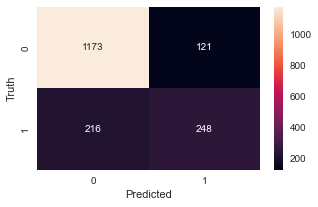

In [ ]:
plt.figure(figsize = (5,3))
sns.heatmap(acc_cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [ ]:

md(f"""
The graph above is based on the test set which includes 25% of our data. <br> 
We have {true_positive_acc_cm } True Positives — these are the customers for which we will be able to extend the lifetime value. If we wouldn’t have predicted, then there was no opportunity for intervention.<br>
We also have {false_positive_acc_cm } ({round((false_positive_acc_cm /total_customers)*100,2)}%) False Positives where we will lose money because the promotion offered to these customers will just be an extra cost.<br>
{true_negative_acc_cm } ({round((true_negative_acc_cm /total_customers)*100,2)}%) are True Negatives (good customers) and {false_negative_acc_cm } ({round((false_negative_acc_cm /total_customers)*100,2)}%) are False Negative (this is a missed opportunity).<br>

In a churn model, often the reward of true positives is way different than the cost of false positives. Let’s use the following assumptions:<br>
- 10,000 SEK voucher will be offered to all the customers identified as churn (True Positive + False Positive):<br>
- If we are able to stop the churn, we will gain 50,000 SEK in customer lifetime value.<br>

Using these assumptions and the confusion matrix above, we can calculate the impact of this model:

Accuracy Model:
| Description   | Customers       | Worth(SEK)    | Total(SEK)             | - |
|---------------|-----------------|---------------|------------------------|---|
| True Positive | {true_positive_acc_cm } | {tp_value_acc_cm }    | {tp_total_acc_cm }             | - |
| TP + FP       | {tp_fp_acc_cm }         | -{tp_fp_value_acc_cm } | -{tp_fp_total_acc_cm }          | - |
| -             | -               | **"PROFIT"-->**             | **{total_profit_acc_cm } SEK** | - |


"""
   )
   


The graph above is based on the test set which includes 25% of our data. <br> 
We have 248 True Positives — these are the customers for which we will be able to extend the lifetime value. If we wouldn’t have predicted, then there was no opportunity for intervention.<br>
We also have 121 (6.88%) False Positives where we will lose money because the promotion offered to these customers will just be an extra cost.<br>
1173 (66.72%) are True Negatives (good customers) and 216 (12.29%) are False Negative (this is a missed opportunity).<br>

In a churn model, often the reward of true positives is way different than the cost of false positives. Let’s use the following assumptions:<br>
- 10,000 SEK voucher will be offered to all the customers identified as churn (True Positive + False Positive):<br>
- If we are able to stop the churn, we will gain 50,000 SEK in customer lifetime value.<br>

Using these assumptions and the confusion matrix above, we can calculate the impact of this model:

Accuracy Model:
| Description   | Customers       | Worth(SEK)    | Total(SEK)             | - |
|---------------|-----------------|---------------|------------------------|---|
| True Positive | 248 | 50000    | 12400000             | - |
| TP + FP       | 369         | -10000 | -3690000          | - |
| -             | -               | **"PROFIT"-->**             | **8710000 SEK** | - |




# Recall Model Results

In [ ]:
true_positive_recall_cm = recall_cm[1][1]
false_positive_recall_cm = recall_cm[0][1]
true_negative_recall_cm = recall_cm[0][0]
false_negative_recall_cm = recall_cm[1][0]

tp_fp_recall_cm = true_positive_recall_cm+false_positive_recall_cm
tp_value_recall_cm = 50000
tp_fp_value_recall_cm = 10000
tp_total_recall_cm = true_positive_recall_cm*50000
tp_fp_total_recall_cm = (true_positive_recall_cm+false_positive_recall_cm)*10000
total_profit_recall_cm = tp_total_recall_cm-tp_fp_total_recall_cm

Text(25.0, 0.5, 'Truth')

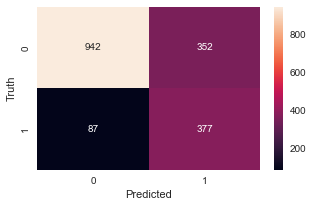

In [ ]:
plt.figure(figsize = (5,3))
sns.heatmap(recall_cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [ ]:


md(f"""
The graph above is based on the test set which includes 25% of our data <br> 
We have {true_positive_recall_cm } True Positives — these are the customers for which we will be able to extend the lifetime value. If we wouldn’t have predicted, then there was no opportunity for intervention.<br>
We also have {false_positive_recall_cm } ({round((false_positive_recall_cm /total_customers)*100,2)}%) False Positives where we will lose money because the promotion offered to these customers will just be an extra cost.<br>
{true_negative_recall_cm } ({round((true_negative_recall_cm /total_customers)*100,2)}%) are True Negatives (good customers) and {false_negative_recall_cm } ({round((false_negative_recall_cm /total_customers)*100,2)}%) are False Negative (this is a missed opportunity).<br>

In a churn model, often the reward of true positives is way different than the cost of false positives. Let’s use the following assumptions:<br>
- 10,000 SEK voucher will be offered to all the customers identified as churn (True Positive + False Positive):<br>
- If we are able to stop the churn, we will gain 50,000 SEK in customer lifetime value.<br>

Using these assumptions and the confusion matrix above, we can calculate the impact of this model:

Recall Model: 
| Description   | Customers       | Worth(SEK)    | Total(SEK)             | - |
|---------------|-----------------|---------------|------------------------|---|
| True Positive | {true_positive_recall_cm } | {tp_value_recall_cm }    | {tp_total_recall_cm }             | - |
| TP + FP       | {tp_fp_recall_cm }         | -{tp_fp_value_recall_cm } | -{tp_fp_total_recall_cm }          | - |
| -             | -               | **"PROFIT"-->**             | **{total_profit_recall_cm } SEK** | - |


"""
   )


The graph above is based on the test set which includes 25% of our data <br> 
We have 377 True Positives — these are the customers for which we will be able to extend the lifetime value. If we wouldn’t have predicted, then there was no opportunity for intervention.<br>
We also have 352 (20.02%) False Positives where we will lose money because the promotion offered to these customers will just be an extra cost.<br>
942 (53.58%) are True Negatives (good customers) and 87 (4.95%) are False Negative (this is a missed opportunity).<br>

In a churn model, often the reward of true positives is way different than the cost of false positives. Let’s use the following assumptions:<br>
- 10,000 SEK voucher will be offered to all the customers identified as churn (True Positive + False Positive):<br>
- If we are able to stop the churn, we will gain 50,000 SEK in customer lifetime value.<br>

Using these assumptions and the confusion matrix above, we can calculate the impact of this model:

Recall Model: 
| Description   | Customers       | Worth(SEK)    | Total(SEK)             | - |
|---------------|-----------------|---------------|------------------------|---|
| True Positive | 377 | 50000    | 18850000             | - |
| TP + FP       | 729         | -10000 | -7290000          | - |
| -             | -               | **"PROFIT"-->**             | **11560000 SEK** | - |




In [ ]:
md(
    f"""
<span style="color:red">**Accuracy Model Score**</span>: {pycaret_best_acc_score}
| Description   | Customers       | Worth(SEK)    | Total(SEK)             | - |
|---------------|-----------------|---------------|------------------------|---|
| True Positive | {true_positive_acc_cm } | {tp_value_acc_cm }    | {tp_total_acc_cm }             | - |
| TP + FP       | {tp_fp_acc_cm }         | -{tp_fp_value_acc_cm } | -{tp_fp_total_acc_cm }          | - |
| -             | -               | **"PROFIT"-->**             | <span style="color:red">**{total_profit_acc_cm } SEK**</span> | - |

<span style="color:green">**Recall Model Score**</span>: {pycaret_best_recall_score}
| Description   | Customers       | Worth(SEK)    | Total(SEK)             | - |
|---------------|-----------------|---------------|------------------------|---|
| True Positive | {true_positive_recall_cm } | {tp_value_recall_cm }    | {tp_total_recall_cm }             | - |
| TP + FP       | {tp_fp_recall_cm }         | -{tp_fp_value_recall_cm } | -{tp_fp_total_recall_cm }          | - |
| -             | -               | **"PROFIT"-->**             | <span style="color:green">**{total_profit_recall_cm } SEK**</span> | - |


**Conclusion:** Just by thinking a step further, not picking the model with the highest accuracy we can "save" {total_profit_recall_cm-total_profit_acc_cm} SEK per {total_customers} customers.

    """
)






<span style="color:red">**Accuracy Model Score**</span>: 0.8083048919226393
| Description   | Customers       | Worth(SEK)    | Total(SEK)             | - |
|---------------|-----------------|---------------|------------------------|---|
| True Positive | 248 | 50000    | 12400000             | - |
| TP + FP       | 369         | -10000 | -3690000          | - |
| -             | -               | **"PROFIT"-->**             | <span style="color:red">**8710000 SEK**</span> | - |

<span style="color:green">**Recall Model Score**</span>: 0.7502844141069397
| Description   | Customers       | Worth(SEK)    | Total(SEK)             | - |
|---------------|-----------------|---------------|------------------------|---|
| True Positive | 377 | 50000    | 18850000             | - |
| TP + FP       | 729         | -10000 | -7290000          | - |
| -             | -               | **"PROFIT"-->**             | <span style="color:green">**11560000 SEK**</span> | - |


**Conclusion:** Just by thinking a step further, not picking the model with the highest accuracy we can "save" 2850000 SEK per 1758 customers.

    

# Conclusion and final words

In [ ]:
print('Manual Modeling Highscores:\n',conclusion.head())
print('-------Hours 300+')
print('\n PyCaret Accuracy AutoML Model:\n score: ',pycaret_best_acc_score)
print('-------Hours 0.01')
print('\n PyCaret Recall AutoML Model:\n score: ',pycaret_best_recall_score)
print('-------Hours 0.01')

Manual Modeling Highscores:
                                       model     score
0               AdaBoostClassifier(Default)  0.807736
1          AdaBoostClassifier(MinMaxScaler)  0.807736
2               LogisticRegression(Default)  0.807736
3          LogisticRegression(MinMaxScaler)  0.800910
4  GradientBoostingClassifier(MinMaxScaler)  0.800341
-------Hours 300+

 PyCaret Accuracy AutoML Model:
 score:  0.8083048919226393
-------Hours 0.01

 PyCaret Recall AutoML Model:
 score:  0.7502844141069397
-------Hours 0.01


Always check the interwebs for tools for the given challenge that you are encountering.<br> 
There is really no point in re-inventing the wheel.